# Model2 RNN

Recursive Neural Network(RNN) is a deep learning model designed for predicting sequencial events. 

Imagine you have a box of colorful beads, and you're trying to make a necklace by putting the beads on a string one by one. You notice that there's a pattern to the colors, like red, blue, green, then red, blue, green again. An RNN helps the computer learn this pattern and guess which color comes next.

The RNN is special because it can remember the colors it saw before and use that memory to make better guesses. So, when it sees a red bead, it thinks, "Ah, I remember, after red comes blue!" This memory helps the computer make more accurate predictions as it learns the pattern of the necklace.

To be more specific, RNN uses some previous events to predict some furture events. This is called many-to-many mode. 

For example, RNN can use 5 sequncial data points X(t-4) to Xt to predict 2 future data points y(t+1) and y(t+2). h(t-4) to h(t) represents the memory cell. 

![2](<https://raw.githubusercontent.com/jh4578/5293finalproject/main/_build/html/_images/RNN2.webp>)

![3](<https://raw.githubusercontent.com/jh4578/5293finalproject/main/_build/html/_images/RNN3.webp>)

![1](<https://raw.githubusercontent.com/jh4578/5293finalproject/main/_build/html/_images/RNN1.webp>)

In [2]:
import pandas as pd
import yfinance as yf
import numpy as np
from matplotlib import pyplot as plt

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/jh4578/5293finalproject/main/GOOG.csv',date_parser = True)

In [4]:
data.index = data['Date']
data.drop(columns = ['Date','Volume'], inplace = True)


In [5]:
data.head()

,Open,High,Low,Close,Adj Close
Date,,,,,
2004-08-19,2.490664,2.591785,2.390042,2.499133,2.499133
2004-08-20,2.515820,2.716817,2.503118,2.697639,2.697639
2004-08-23,2.758411,2.826406,2.716070,2.724787,2.724787
2004-08-24,2.770615,2.779581,2.579581,2.611960,2.611960
2004-08-25,2.614201,2.689918,2.587302,2.640104,2.640104


In [6]:
data[:'2019'].iloc[:,0:1].values

array([[ 2.490664],
       [ 2.51582 ],
       [ 2.758411],
       ...,
       [50.857498],
       [52.480999],
       [52.548   ]])

Here we define a function organize train and test data set. We will use the data from 2004 to 2019 to train the model and the other used for test. 

In [7]:
time_step_in = 5
time_step_out = 2

# Split training and testing data
data_train = data[:'2019'].iloc[:,0:1].values
data_test = data['2019':].iloc[:,0:1].values
data_value = data.iloc[:,0:1].values

# Scale the data
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
data_sc = sc.fit_transform(data_value)

# Create X_train and y_train 
X_train = []
y_train = []
for i in range(time_step_in,len(data_train) - time_step_out - 1):
  X_train.append(data_sc[i - time_step_in:i, 0])
  y_train.append(data_sc[i:i + time_step_out,0])


X_train, y_train = np.array(X_train), np.array(y_train)
# We can take a look at the X_train and y_train
#print(pd.concat([pd.DataFrame(X_train),pd.DataFrame(y_train)],axis = 1))

X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

X_test = []
# Create X_test
for i in range(len(data_train) - time_step_out - 1, len(data_sc) - time_step_out - 1 ):
  X_test.append(data_sc[i - time_step_in:i,0])
X_test = np.array(X_test)
print(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

[[0.32952688 0.32421874 0.32327155 0.30941549 0.31447262]
 [0.32421874 0.32327155 0.30941549 0.31447262 0.32389072]
 [0.32327155 0.30941549 0.31447262 0.32389072 0.33475804]
 ...
 [0.69226473 0.69126067 0.6884493  0.67291979 0.67104555]
 [0.69126067 0.6884493  0.67291979 0.67104555 0.66247755]
 [0.6884493  0.67291979 0.67104555 0.66247755 0.66428484]]


In [8]:
def actual_pred_plot(preds):
    actual_pred = pd.DataFrame(columns = ['Open', 'prediction'])
    actual_pred['Open'] = data.loc['2019':,'Open'][0:len(preds)]
    actual_pred['prediction'] = preds[:,0]

    from keras.metrics import MeanSquaredError
    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['Open']),np.array(actual_pred['prediction']))
    
    return (m.result().numpy(), actual_pred.plot() )
    

In [9]:
def RNN_model(X_train, y_train, X_test, sc):
    
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN
    
    my_rnn_model = Sequential()
    my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    my_rnn_model.add(SimpleRNN(32))
    my_rnn_model.add(Dense(time_step_out))
    my_rnn_model.compile(optimizer='rmsprop', loss='mean_squared_error')

    # fit the RNN model
    my_rnn_model.fit(X_train, y_train, epochs=100, batch_size=150, verbose=0)

    # Finalizing predictions
    rnn_predictions = my_rnn_model.predict(X_test)
    from sklearn.preprocessing import MinMaxScaler
    rnn_predictions = sc.inverse_transform(rnn_predictions)

    return my_rnn_model, rnn_predictions

34/34 [==============================] - 0s 2ms/step


(82.80035, <Axes: xlabel='Date'>)

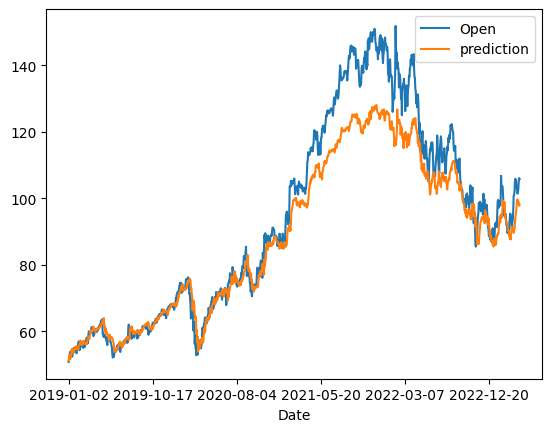

In [10]:
my_RNN_model, RNN_prediction = RNN_model(X_train, y_train, X_test, sc)
actual_pred_plot(RNN_prediction) 

The prediction looks great, BUT that is because every predictions I made was based on real data, not the predicted data. 

If I want to predict the stock without the real data (we cannot get real data for stock in future), I need to use the Recursive Multi-step Forecast Strategy.

1/1 [==============================] - 0s 24ms/step


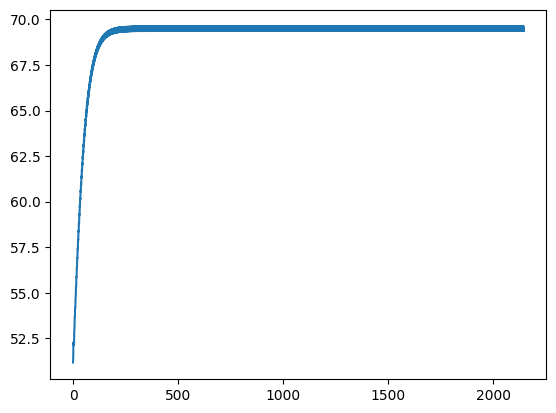

In [11]:
# predict with the test data
input_sequence = X_test[0].reshape(1, time_step_in, 1)
# Initialize an empty list to store predictions
predictions = []

for i in range(len(X_test)):
    # Predict the next time_step_out points using the current input_sequence
    pred = my_RNN_model.predict(input_sequence)
    
    # Add the predicted points to the predictions list
    predictions.extend(pred[0])
    
    # Update the input_sequence by adding the predicted points and removing the first time_step_out points
    input_sequence = np.roll(input_sequence, -time_step_out)
    input_sequence[0, -time_step_out:] = pred.reshape(-1,1)

# Inverse transform the predictions
predictions = sc.inverse_transform(np.array(predictions).reshape(-1, 1))
plt.plot(predictions)